# Flower Classification
<br>


## This work is the capstone project of the Pytorch Scholarship Challenge on Udacity. A deep learning algorithm is trained for an image classification task using a [dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) containing images of 102 different species of flowers.
<br>

### In the  AI era, artificial inteligence algorithms will be incorporated into more and more everyday applications. An app that depicts a flower specie's name your camera is looking at might be wanted. For this, a way of seeing an image and then classifying it from a pool of labels may be enough to give what is needed. In such a situation, you want to include an image classifier in a smart phone app. Hence, we can use a deep learning model, pre-trained on hundreds of thousands of images as part of the overall application architecture.
<br>

### In this project, I'll present how to train just a part of a pre-trained CNN model (the classifier) to be used as an image labeling algorithm, as a way of saving time and sculpting a model to suit our needs, so it can be exported for use in an application.
<br>


## The project is broken down into five major steps:
### 1) Data exploration 
### 2) Dataset loading and preprocessing
### 3) Train the image classifier on the dataset
### 4) Use the trained model to predict new content
### 5) Conclusion
<br>

#### Throughout this python implemented kernel, we'll get in touch with the **PyTorch** framework, **CNNs** as a Deep Learning strategy for computer vision and how to use a pre-trained model in our favor by using **transfer leaning**. 

In [0]:
# Setting up virtual machine
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Installing PyTorch on Virtual Machine

# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

tcmalloc: large alloc 1073750016 bytes == 0x579d6000 @  0x7fcf78d1f2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [0]:
# Dealing with import bugs
!pip install pillow==4.1.1
%reload_ext autoreload
%autoreload

    100% |████████████████████████████████| 5.7MB 5.7MB/s 
  Found existing installation: Pillow 5.4.1
    Uninstalling Pillow-5.4.1:
      Successfully uninstalled Pillow-5.4.1
  [PIL]
You must restart the runtime in order to use newly installed versions.


In [0]:
# install required packagles
!pip install torchsummary

In [0]:
# Data science
import numpy as np
import pandas as pd

# PyTorch framework
import torch
import torchvision
from torch import cuda
from torchvision import datasets, transforms, models
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchsummary import summary

# Image tools
import matplotlib.pyplot as plt
from PIL import Image

# Others
import json
from timeit import default_timer as timer
import os, random


In [0]:
# Showing the available GPU
torch.cuda.get_device_name(0)

'Tesla K80'

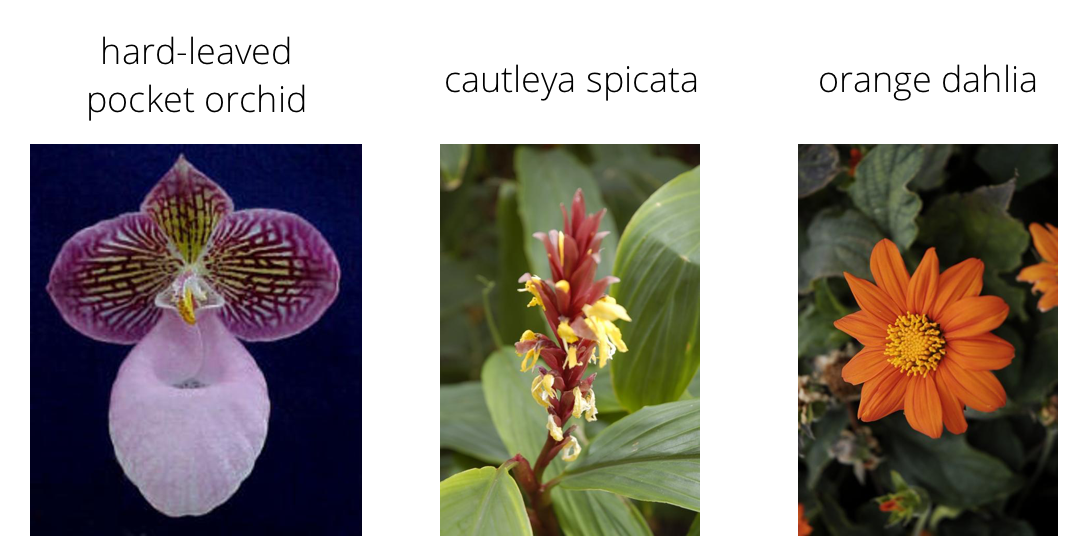

In [0]:
# Flower examples and its species
Image.open('drive/My Drive/Colab/Flowers.png')

## 1) Data exploration
### The dataset is structured in a folder called 'flower_data'. Inside, there are three different folders called 'train', 'valid' and 'test' with data split for its purposes. Each folder contains 102 folders named from 1 to 102, which contain images of its respectives flower species.
### The folders' names goes from 1 to 102 so it need to be mapped from category label to category name.

In [0]:
# Getting the label of the encripted flower species of the dataset folders from a json file
# which contains a dictionary mapping the integer encoded categories to the actual names of the flowers
with open('drive/My Drive/Colab/cat_to_name.json', 'r') as f:
    category_to_name = json.load(f)

print('Classes number:', len(category_to_name), '\n')
print(category_to_name)

Classes number: 102 

{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved po

In [0]:
# Data paths
data_dir = 'drive/My Drive/Colab/Flower_Dataset/'
train_dir = data_dir + 'train/'
valid_dir = data_dir + 'valid/'
test_dir = data_dir + 'test/'

In [0]:
# Accounting for the number of images of each category in each split
# Creating lists of the amount of data
train_num = []
valid_num =[]
test_num = []
category_names = []

for label in os.listdir(train_dir):
    category_names.append(category_to_name[label])
    train_num.append(len(os.listdir(train_dir + '/' + label)))
    valid_num.append(len(os.listdir(valid_dir + '/' + label)))
    test_num.append(len(os.listdir(test_dir + '/' + label)))

# Putting it into a dataframe for easy manipulation
category_names_df = pd.DataFrame({
    'Category': category_names,
    'Train_num': train_num,
    'Valid_num': valid_num,
    'Test_num': test_num})

In [0]:
# Amount of data in each split
print('Data samples in the Training set:', sum(category_names_df['Train_num']))
print('Data samples in the Validation set:', sum(category_names_df['Valid_num']))
print('Data samples in the Test set:', sum(category_names_df['Test_num']))

Data samples in the Training set: 6554
Data samples in the Validation set: 818
Data samples in the Test set: 820


In [0]:
# Max category counts in descending order for training, validation and test set
print(category_names_df.sort_values('Train_num', ascending=False).head(), '\n')
print(category_names_df.sort_values('Valid_num', ascending=False).head(), '\n')
print(category_names_df.sort_values('Test_num', ascending=False).head(), '\n')

          Category  Test_num  Train_num  Valid_num
52         petunia        24        206         28
77  passion flower        25        205         21
45      wallflower        21        157         18
95      watercress        15        153         16
73      water lily        28        147         19 

          Category  Test_num  Train_num  Valid_num
52         petunia        24        206         28
97        cyclamen        13        116         25
77  passion flower        25        205         21
74   morning glory         4         83         20
73      water lily        28        147         19 

          Category  Test_num  Train_num  Valid_num
73      water lily        28        147         19
77  passion flower        25        205         21
52         petunia        24        206         28
45      wallflower        21        157         18
82        clematis        17         82         13 



In [0]:
# Min category counts in descending order for training, validation and test set
print(category_names_df.sort_values('Train_num', ascending=False).tail(), '\n')
print(category_names_df.sort_values('Valid_num', ascending=False).tail(), '\n')
print(category_names_df.sort_values('Test_num', ascending=False).tail(), '\n')

            Category  Test_num  Train_num  Valid_num
30        siam tulip         5         33          3
75       moon orchid         6         33          1
35  love in the mist         8         31          7
33     mexican aster         5         28          7
2      pink primrose         6         27          8 

                    Category  Test_num  Train_num  Valid_num
24                 carnation         2         48          2
8              spear thistle         3         44          1
63                tiger lily         9         35          1
75               moon orchid         6         33          1
22  prince of wales feathers         3         36          1 

            Category  Test_num  Train_num  Valid_num
90         monkshood         2         41          3
15         fire lily         2         34          4
23  canterbury bells         2         36          2
24         carnation         2         48          2
25        red ginger         2         35      

Text(0.5, 1.0, 'Training samples by category')

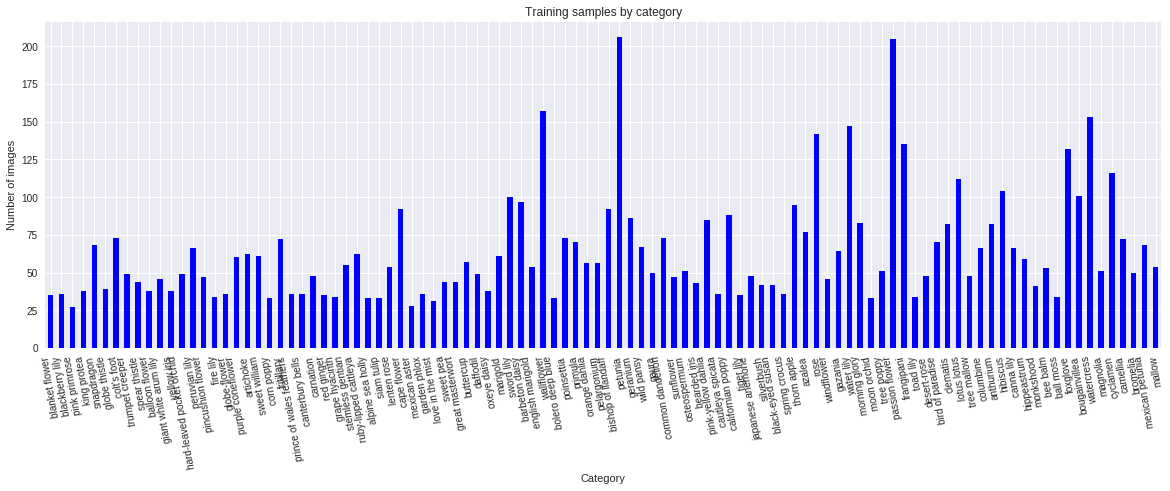

In [0]:
# Distribution of training samples
category_names_df.set_index('Category')['Train_num'].plot.bar(color='b', figsize=(20, 6))
plt.xticks(rotation=100)
plt.ylabel('Number of images')
plt.title('Training samples by category')

Random training sample shape and image: (501, 653, 3) 



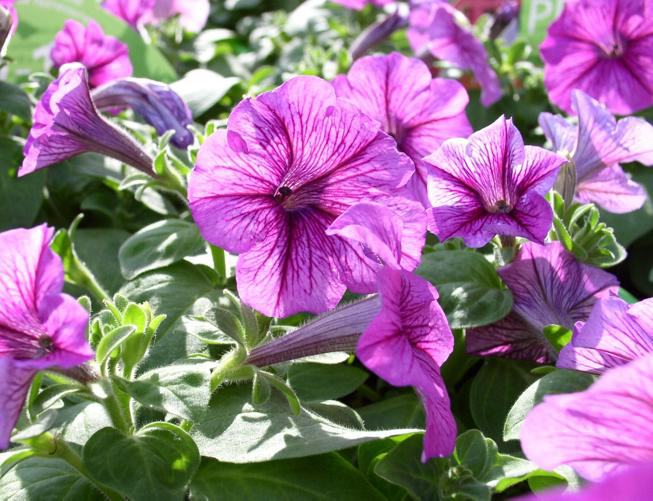

In [0]:
# Displaiyng a random image and its shape
random_class = random.choice(os.listdir(train_dir)) # Selecting a random class from the train folder
random_image = random.choice(os.listdir(train_dir + '/' + random_class)) # Selecting a random image from the random selected class folder
img = Image.open(train_dir + random_class + '/' + random_image)
print('Random training sample shape and image:', np.array(img).shape, '\n')
img

## 2) Preprocessing and Loading 
### We'll use the *torchvision* ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)) module and the data can be downloaded [here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). It's good to mind that the first dataset link goes to the authors' website regarding the original data paper, where we can download it in an unstructured format; whereas the previous link stores the dataset with a folder class-separated architecture suitable to PyTorch implementation, as shown bellow:

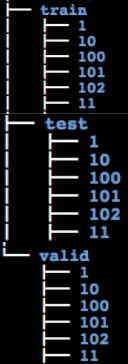

In [0]:
Image.open('drive/My Drive/Colab/1_rK04bDQAIV8wsIDAXmev9Q.png')

### 2.1) Transformation

#### 2.1.1) Data Augmentation
#### As the trained model yields better results with larger amounts of data, we can use image augmentation to synthetically create more and slightly modified images that'll be fed to the network which can lead to a better real-world generalization. As seen above, the training samples may have a size different from the one supported by Imagenet models' network (224 x 224) so it'll need resizing them.
#### The images can then undergo cropping, resizing, flipping, rotating, among other transformations.

In [0]:
# Saving the upcoming model in a file
save_file_name = 'flower_classifier.pt'
checkpoint_path = 'flower_classifier.pth'

In [0]:
# Transforming the training dataset for better generalization
# Converting and transforming data to a normalized torch.FloatTensor
data_transforms_train = transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=180),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.CenterCrop(size=224), # Imagenet standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]) # Imagenet standards
    
data_transforms_valid = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224), # Imagenet standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]) # Imagenet standards

data_transforms_test = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224), # Imagenet standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]) # Imagenet standards

### 2.2) Loading

#### 2.2.1) Data Load

In [0]:
# Loading the data into a suitable structure
image_dataset_train = torchvision.datasets.ImageFolder(train_dir, transform = data_transforms_train) 
image_dataset_valid = torchvision.datasets.ImageFolder(valid_dir, transform = data_transforms_valid)
image_dataset_test = torchvision.datasets.ImageFolder(test_dir, transform = data_transforms_test) 

# Passing it to a data loader for batches feeding
dataloader_train = torch.utils.data.DataLoader(image_dataset_train, shuffle=True, batch_size=32)
dataloader_valid = torch.utils.data.DataLoader(image_dataset_valid, shuffle=True, batch_size=32)
dataloader_test = torch.utils.data.DataLoader(image_dataset_test, shuffle=True, batch_size=32)

#### 2.2.2) Image presentation after transformation and loading

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 3, 224, 224]) torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


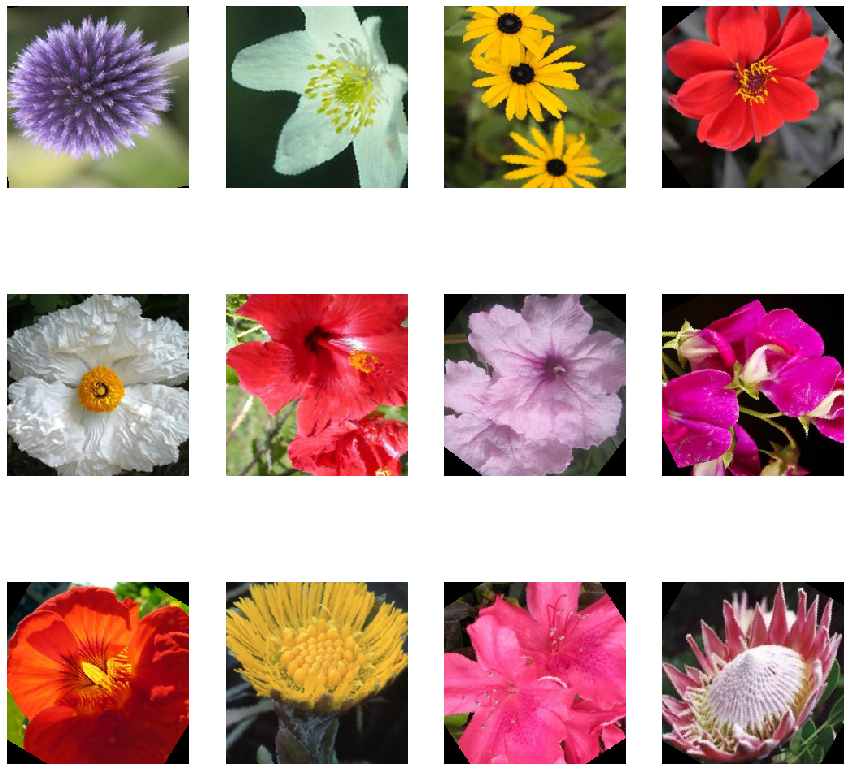

In [0]:
# Visualizing images from the train dataloader
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
images, labels = next(iter(dataloader_train))
print(images.shape, labels.shape)
rows = 3
columns = 4
fig=plt.figure(figsize=(15,15))
for i in range(12):
  fig.add_subplot(rows, columns, i+1)
  plt.title(None).set_visible(False)
  img = images[i].numpy().transpose((1, 2, 0))
  img = std * img + mean
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img, interpolation='nearest')
  
plt.show()

# With this some images can be seen as cropped, upside down and even tilted in different angles

#### We can check the batch size, the images size and the transformation display of samples after the loading. As in each epoch the whole data passes through the network, for each epoch a different random transformation will take place thus creating different versions of the same image samples.

## 3) Training the model

### 3.1) Building the classifier

### As the dataset used is relatively small (less than 1000 samples per class) this work will focus on training only the classifier, using transfer learning from the DenseNet-161 pre-trained model ([paper](https://arxiv.org/pdf/1608.06993.pdf)) as it will provide the convolutional archtecture with its weights. The choice of DenseNet was made by its low error ratio (according to PyTorch [documentation](https://pytorch.org/docs/master/torchvision/models.html) on pre-trained models) with fairly low computational effort, while it used the ImageNet database which contains similar (flower, plants) content with this work.
### Once this work will use the pre-trained model's weights, the feature parameters will be frozen and we will only consider to train the classifier portion as the original model was designed to classify 1000 different classes and we will only need 102 output features.

In [0]:
# Defining the model
model = models.densenet161(pretrained=True)

# Making sure the model's features parameters do not get updated as we train the classifier
for param in model.parameters():
    param.requires_grad = False

# Checking the model characteristics
print('\n', 'Model prior to modifications', '\n')
model

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.torch/models/densenet161-8d451a50.pth
100%|██████████| 115730790/115730790 [00:02<00:00, 55994527.03it/s]



 Model prior to modifications 



DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inpla

In [0]:
# Dealing only with the classifier
print('Model classifier before modifications')
print(model.classifier, '\n')

# Replacing the model's classifier for our own
n_inputs = model.classifier.in_features # Getting the model's input size
model.classifier = nn.Sequential(
    nn.Linear(n_inputs, 1000),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(1000, 500),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(500, 102),
    nn.LogSoftmax(dim=1))

print('Model classifier after modifications', '\n')
print(model.classifier)

Model classifier before modifications
Linear(in_features=2208, out_features=1000, bias=True) 

Model classifier after modifications 

Sequential(
  (0): Linear(in_features=2208, out_features=1000, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.4)
  (3): Linear(in_features=1000, out_features=500, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.4)
  (6): Linear(in_features=500, out_features=102, bias=True)
  (7): LogSoftmax()
)


In [0]:
# Assigning an available GPU
train_on_gpu = torch.cuda.is_available()
train_on_gpu

True

In [0]:
# Using GPU if available
if train_on_gpu:
    model.cuda()
    print('Model moved to GPU')

Model moved to GPU


In [0]:
# Defining the training loss and optimizer after model going to GPU
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr= 0.001)

### 3.2) Training the classifier

### A function bellow called 'train' was constructed to ease the monitoring and control over the classifier training. After one complete data pass through the network (epoch) It uses the defined loss criteria to calculate its gradients with respect to the model parameters using backpropagation. Afterwards the chosen optimizer will update them. 
<br>

### The training and validation loss as well as the training and validation accuracy will be printed along the training, and as the validation loss decreases the model parameters will be saved. The looping will continue up to maximum selected number of epochs or if the validation loss will not be lowered for 5 consecutive epochs, then the training will have an early stopping.

In [0]:
def train(model, train_loader, valid_loader, criterion, optimizer, save_file_name, max_epochs=5, num_epochs=50, print_every=2):
    """Training a model on PyTorch
    
    ***Parameters:
    model(PyTorch model): CNN model chosen to be trained on.
    train_loader(PyTorch dataloader): training dataloader
    valid_loader(PyTorch dataloader): validation dataloader
    criterion(PyTorch loss): function chosen to minimize the loss between model output and target
    optimizer(PyTorch optimizer): optimizer function to compute gradients of model parameters
    save_file_name(str ending in '.pt'): file path and name in quotes to save the model state dict .pt
    max_epochs(int): maximum number of epochs with no improvement in validation loss for early stopping
    num_epochs(int): maximum number of training epochs
    print_every(int): frequency of epochs to print training stats
    
    ***Returns:
    model(PyTorch model): trained CNN with best (lowest validation loss) weights
    hist(DataFrame): history of train and validation loss and accuracy
    """
    
    epochs_no_improve = 0
    overall_start = timer()
    valid_loss_min = np.Inf
    valic_acc_max = 0
    hist = []
    train_on_gpu = torch.cuda.is_available()
    
    for epoch in range(num_epochs):
        
        # Keeping track of training and validation losses
        train_loss = 0.0
        valid_loss = 0.0
        # Monitoring accuracy
        train_acc = 0.0
        valid_acc = 0.0
        # Train mode on
        model.train()
        start = timer()
        
        # Training loop
        for ii, (data, target) in enumerate(dataloader_train):
            # Tensors to GPU
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
                
            # Main training steps
            optimizer.zero_grad() # Clearing previous gradients
            output = model(data) # Making data pass through the model and return output as log probabilities
            loss = criterion(output, target) # Calculating the loss diference between output and true targets
            loss.backward() # Passing the loss backwards
            optimizer.step() # Updating the model's parameters
            
            # Losses and accuracy
            train_loss += loss.item() * data.size(0) # Monitoring training loss of all samples in batch
            _, pred = torch.max(output, dim=1) # Calculating accuracy of max log probability
            correct_tensor = pred.eq(target.data.view_as(pred))
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor)) # Converting tensor from int to float and finally average
            train_acc += accuracy.item() * data.size(0) # Monitoring accuracy of all samples in batch
                   
        # Validation
        with torch.no_grad(): # Do not update gradients on validation
            model.eval() # Setting to evaluation mode

            # Main validation loop
            for data, target in dataloader_valid:
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda() # Tensors to gpu

                # Main validation steps
                output = model(data) # Passing data through model with learned new weights
                loss = criterion(output, target)
                valid_loss += loss.item() * data.size(0)

                # Accuracy
                _, pred = torch.max(output, dim=1)
                correct_tensor = pred.eq(target.data.view_as(pred))
                accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
                valid_acc += accuracy.item() * data.size(0)

            # Calculate average losses
            train_loss = train_loss / len(dataloader_train.dataset)
            valid_loss = valid_loss / len(dataloader_valid.dataset)

            # Calculate average accuracy
            train_acc = train_acc / len(dataloader_train.dataset)
            valid_acc = valid_acc / len(dataloader_valid.dataset)

            hist.append([train_loss, valid_loss, train_acc, valid_acc])

            # Printing training and validation results
            if (epoch + 1) % print_every == 0:
                print(
                    f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                )
                print(
                    f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                )

            # Save the model if validation loss decreases
            if valid_loss < valid_loss_min:
                torch.save(model.state_dict(), save_file_name) # Save model
                print('Validation loss decreased -> Saving model')

                epochs_no_improve = 0 # Track improvement
                valid_loss_min = valid_loss
                valid_best_acc = valid_acc
                best_epoch = epoch

            # Otherwise increment count of epochs with no improvement
            else:
                epochs_no_improve += 1
                # Trigger early stopping
                if epochs_no_improve >= max_epochs:
                    print(
                        f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                    )
                    total_time = timer() - overall_start
                    print(
                        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                    )

                    # Load the best state dict
                    model.load_state_dict(torch.load(save_file_name))
                    # Attach the optimizer
                    model.optimizer = optimizer

                    # Format history
                    hist = pd.DataFrame(
                        hist,
                        columns=[
                            'train_loss', 'valid_loss', 'train_acc',
                            'valid_acc'
                        ])
                    return model, hist

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # Format history
    hist = pd.DataFrame(
        hist,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, hist

In [0]:
model, hist = train(
    model,
    train_loader = dataloader_train,
    valid_loader = dataloader_valid,
    criterion = nn.NLLLoss(),
    optimizer = optim.Adam(model.classifier.parameters(), lr= 0.001),
    save_file_name = 'flower_classifier.pt',
    max_epochs = 5,
    num_epochs = 50,
    print_every = 1)


Epoch: 0 	Training Loss: 3.5827 	Validation Loss: 2.0232
		Training Accuracy: 19.09%	 Validation Accuracy: 49.14%
Validation loss decreased -> Saving model

Epoch: 1 	Training Loss: 1.7448 	Validation Loss: 1.1697
		Training Accuracy: 52.52%	 Validation Accuracy: 67.73%
Validation loss decreased -> Saving model

Epoch: 2 	Training Loss: 1.2442 	Validation Loss: 0.8884
		Training Accuracy: 64.51%	 Validation Accuracy: 74.94%
Validation loss decreased -> Saving model

Epoch: 3 	Training Loss: 1.0080 	Validation Loss: 0.7236
		Training Accuracy: 70.82%	 Validation Accuracy: 79.71%
Validation loss decreased -> Saving model

Epoch: 4 	Training Loss: 0.8391 	Validation Loss: 0.5663
		Training Accuracy: 75.50%	 Validation Accuracy: 84.23%
Validation loss decreased -> Saving model

Epoch: 5 	Training Loss: 0.7543 	Validation Loss: 0.5333
		Training Accuracy: 77.81%	 Validation Accuracy: 85.45%
Validation loss decreased -> Saving model

Epoch: 6 	Training Loss: 0.7158 	Validation Loss: 0.4782


### 3.3 Testing the Network


### After the classifier has been trained it's time to use the new weights to check the new network on unseen data, the test set.

In [0]:
def accuracy_all(output, target, topk=(1, )):
    """Compute the topk accuracy(s)"""
    if train_on_gpu:
        output = output.to('cuda')
        target = target.to('cuda')

    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        # Find the predicted classes and transpose
        _, pred = output.topk(k=maxk, dim=1, largest=True, sorted=True)
        pred = pred.t()

        # Determine predictions equal to the targets
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []

        # For each k, find the percentage of correct
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size).item())
        
        # Computing accuracy for all test set
        acc[0] = acc[0] + res[0]
        acc[1] = acc[1] + res[1]       

In [0]:
# Calculating the average accuracy on the test set for all batches
acc = [0,0]
for i, (features, targets) in enumerate(dataloader_test):
  if train_on_gpu:
    model.to('cuda')
    accuracy_all(model(features.to('cuda')), targets, topk=(1, 5))
  else:
      accuracy(model(features), targets, topk=(1, 5))
print('Top 1 Accuracy:', round(acc[0]/len(dataloader_test), 1))
print('Top 5 Accuracy:', round(acc[1]/len(dataloader_test), 1))

Top 1 Accuracy: 89.1
Top 5 Accuracy: 98.4


### So calculating the average accuracy over all batches of the test set yielded a 89.1% accuracy for the top 1 class and 98.4% for the true class being on the top 5 probable classes.

### 3.4) Saving and loading checkpoint

In [0]:
# Saving checkpoint
model.class_to_idx = dataloader_train.dataset.class_to_idx
checkpoint = {'input_size': [3, 224, 224],
                 'batch_size': dataloader_train.batch_size,
                  'output_size': 102,
                  'state_dict': model.state_dict(),
                  'optimizer': model.optimizer,
                  'optimizer_dict':optimizer.state_dict(),
                  'optimizer_state_dict': model.optimizer.state_dict(),
                  'classifier': model.classifier,
                  'class_to_idx': model.class_to_idx}

torch.save(checkpoint, checkpoint_path)

### After saving the checkpoint we can load it later on to use it:

In [0]:
# Loading checkpoint
def load_checkpoint(path):
    """Load a PyTorch model checkpoint

    Params
    --------
        path (str): saved model checkpoint file path.
    """

    # Load in checkpoint
    checkpoint = torch.load(path)
    
    # Assigning the model
    model = models.densenet161(pretrained=True)
    print('\n', 'Model classifier prior to training:', '\n')
    print(model.classifier, '\n')
    
    # Make sure to set parameters as not trainable
    for param in model.parameters():
        param.requires_grad = False
        
    # Assigning the trained classifier
    model.classifier = checkpoint['classifier']
    print('Trained model classifier:', '\n')
    print(model.classifier, '\n')

    # Load in the state dict
    model.load_state_dict(checkpoint['state_dict'])

    total_params = sum(p.numel() for p in model.parameters())
    print(f'{total_params:,} total parameters.')
    total_trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad)
    print(f'{total_trainable_params:,} total gradient parameters.')

    # Move to gpu
    if torch.cuda.is_available():
        model = model.to('cuda')

    # Model basics
    model.class_to_idx = checkpoint['class_to_idx']

    # Optimizer
    optimizer = checkpoint['optimizer']
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    return model, optimizer

In [0]:
# Assigning checkpoint path and loading it
loading_path = 'drive/My Drive/Colab/' + checkpoint_path
model, optimizer = load_checkpoint(path=loading_path)

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.torch/models/densenet161-8d451a50.pth
100%|██████████| 115730790/115730790 [00:03<00:00, 35800052.20it/s]



 Model classifier prior to training: 

Linear(in_features=2208, out_features=1000, bias=True) 

Trained model classifier: 

Sequential(
  (0): Linear(in_features=2208, out_features=1000, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.4)
  (3): Linear(in_features=1000, out_features=500, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.4)
  (6): Linear(in_features=500, out_features=102, bias=True)
  (7): LogSoftmax()
) 

29,232,602 total parameters.
2,760,602 total gradient parameters.


### 3.5) Inference


### Now comes the analysis part of the results. The model classifier has been trained. New weights were added and saved in the 'flower_model_transfer.pt' file. As we can see, the training took around 1 hour to finish with an early stop on epoch 15 yielding a model with 90% accurary on the validation set.
### Let's see how the train and validation  accuracy behaved along the training:

Text(0.5, 1.0, 'Training and Validation Accuracy')

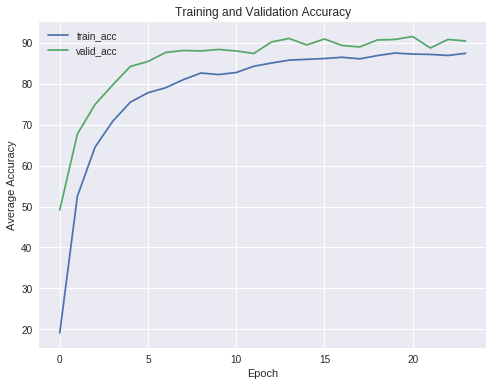

In [0]:
plt.figure(figsize=(8, 6))
for loss in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * hist[loss], label=loss)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

### The rapid increase in accuracy followed by a transition to a plateau with some fluctuations is expected, moreover, with the dropout, the validation accuracy increased higher than the training.

In [0]:
summary(model, input_size=(3, 224, 224), batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 96, 112, 112]          14,112
       BatchNorm2d-2         [32, 96, 112, 112]             192
              ReLU-3         [32, 96, 112, 112]               0
         MaxPool2d-4           [32, 96, 56, 56]               0
       BatchNorm2d-5           [32, 96, 56, 56]             192
              ReLU-6           [32, 96, 56, 56]               0
            Conv2d-7          [32, 192, 56, 56]          18,432
       BatchNorm2d-8          [32, 192, 56, 56]             384
              ReLU-9          [32, 192, 56, 56]               0
           Conv2d-10           [32, 48, 56, 56]          82,944
      BatchNorm2d-11          [32, 144, 56, 56]             288
             ReLU-12          [32, 144, 56, 56]               0
           Conv2d-13          [32, 192, 56, 56]          27,648
      BatchNorm2d-14          [32, 192,

### We can check the model's structure and trainable parameters. Now let's use the trained model to see how it will respond and display predictions:

In [0]:
# Creating a idx to class mapping dict
model.idx_to_class={}
for i, idx in model.class_to_idx.items():
  model.idx_to_class[idx]=category_to_name[i]

In [0]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model.
    
        Params
        --------
        image(str): path to the image.
        
        Return
        --------       
        An Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model

    size = 256, 256
    image.thumbnail(size, Image.ANTIALIAS)
    image = image.crop((128 - 112, 128 - 112, 128 + 112, 128 + 112))
    npImage = np.array(image)
    npImage = npImage/255.
        
    imgA = npImage[:,:,0]
    imgB = npImage[:,:,1]
    imgC = npImage[:,:,2]
    
    imgA = (imgA - 0.485)/(0.229) 
    imgB = (imgB - 0.456)/(0.224)
    imgC = (imgC - 0.406)/(0.225)
        
    npImage[:,:,0] = imgA
    npImage[:,:,1] = imgB
    npImage[:,:,2] = imgC
    
    npImage = np.transpose(npImage, (2,0,1))
    
    return npImage

In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

In [0]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    
    image = torch.FloatTensor([process_image(Image.open(image_path))])
    model.eval()
    model.to('cpu')
    output = model.forward(Variable(image))
    pobabilities = torch.exp(output).data.numpy()[0]
    

    top_idx = np.argsort(pobabilities)[-topk:][::-1]
    top_class = [model.idx_to_class[x] for x in top_idx]
    top_probability = pobabilities[top_idx]

    return top_probability, top_class

In [0]:
# Calling a prediction of an image top 5 class probability and its respective predicted classes 
print (predict('drive/My Drive/Colab/Flower_Dataset/test/102/image_08004.jpg', model))

(array([9.9260241e-01, 2.9509242e-03, 2.1477954e-03, 4.2402811e-04,
       3.7046094e-04], dtype=float32), ['blackberry lily', 'mallow', 'fritillary', 'yellow iris', 'tiger lily'])


### Above it's the top 5 class probability of an image and its respective class name. Let's check these out of some images in a graph, with its true class depicted above the image:

In [0]:
def view_classify(img, probabilities, classes, mapper):
    ''' Function for viewing an image with its true class and the model's top5 predicted classes.       
    '''
    img_filename = img.split('/')[-2]
    img = Image.open(img)

    fig, (ax1, ax2) = plt.subplots(figsize=(6,10), ncols=1, nrows=2)
    flower_name = mapper[img_filename]
    
    ax1.set_title(flower_name)
    ax1.imshow(img)
    ax1.axis('off')
    
    y_pos = np.arange(len(probabilities))
    ax2.barh(y_pos, probabilities)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels([x for x in classes])
    ax2.invert_yaxis()

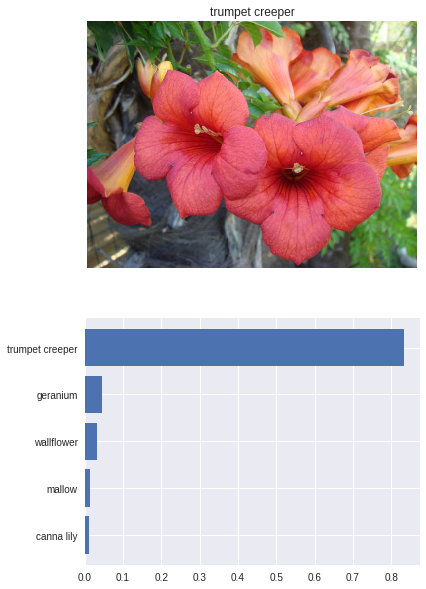

In [0]:
# Assigning a random image path
random_class = random.choice(os.listdir(test_dir)) # Selecting a random class from the test folder
random_image = random.choice(os.listdir(test_dir + '/' + random_class)) # Selecting a random image from the test folder
img_path = test_dir + random_class + '/' + random_image
p, c = predict(img_path, model)

# Calling a random image to display its former class(on top of the image) and top 5 predicted classes
view_classify(img_path, p, c, category_to_name)

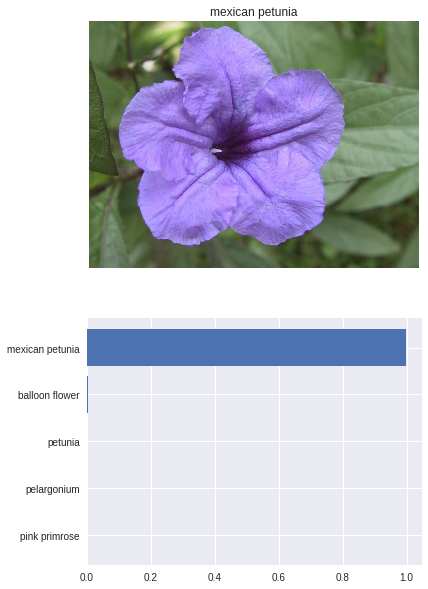

In [0]:
# Assigning a random image path
random_class = random.choice(os.listdir(test_dir)) # Selecting a random class from the test folder
random_image = random.choice(os.listdir(test_dir + '/' + random_class)) # Selecting a random image from the test folder
img_path = test_dir + random_class + '/' + random_image
p, c = predict(img_path, model)

# Calling a random image to display its former class and top 5 predicted classes
view_classify(img_path, p, c, category_to_name)

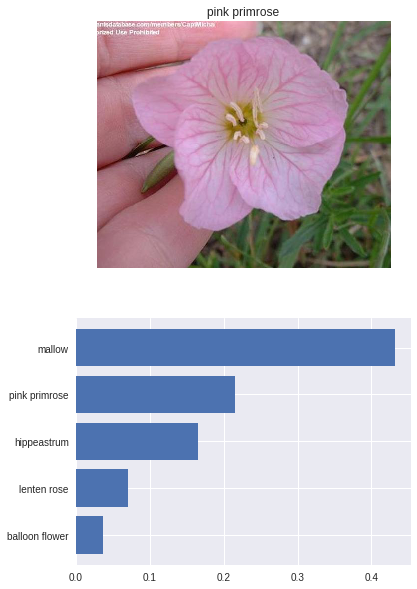

In [0]:
# Assigning a random image path
random_class = random.choice(os.listdir(test_dir)) # Selecting a random class from the test folder
random_image = random.choice(os.listdir(test_dir + '/' + random_class)) # Selecting a random image from the test folder
img_path = test_dir + random_class + '/' + random_image
p, c = predict(img_path, model)

# Calling a random image to display its former class and top 5 predicted classes
view_classify(img_path, p, c, category_to_name)

### So the model presented good accuracy, although it still has its flaws. We can see that with three random samples the model was able to correctly identify two of them, as the last image only had its correct label on the model's second choice.
### Hence, the model does better in some classes and worse in others. Let's dig in:

In [0]:
def accuracy(output, target, topk=(1, )):
    """Compute the topk accuracy(s)"""
    if train_on_gpu:
        output = output.to('cuda')
        target = target.to('cuda')

    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        # Find the predicted classes and transpose
        _, pred = output.topk(k=maxk, dim=1, largest=True, sorted=True)
        pred = pred.t()

        # Determine predictions equal to the targets
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []

        # For each k, find the percentage of correct
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size).item())
        return res

In [0]:
def evaluate(model, test_loader, criterion, topk=(1, 5)):
    """Measure the performance of a trained PyTorch model

    Params
    --------
        model (PyTorch model): trained cnn for inference
        test_loader (PyTorch DataLoader): test dataloader
        topk (tuple of ints): accuracy to measure

    Returns
    --------
        results (DataFrame): results for each category

    """

    classes = []
    losses = []
    # Hold accuracy results
    acc_results = np.zeros((len(test_loader.dataset), len(topk)))
    i = 0

    model.eval()
    with torch.no_grad():

        # Testing loop
        for data, targets in test_loader:

            # Tensors to gpu
            if train_on_gpu:
                data, targets = data.to('cuda'), targets.to('cuda')

            # Raw model output
            out = model(data)
            # Iterate through each example
            for pred, true in zip(out, targets):
                # Find topk accuracy
                acc_results[i, :] = accuracy(
                    pred.unsqueeze(0), true.unsqueeze(0), topk)
                classes.append(model.idx_to_class[true.item()])
                # Calculate the loss
                loss = criterion(pred.view(1, 102), true.view(1))
                losses.append(loss.item())
                i += 1

    # Send results to a dataframe and calculate average across classes
    results = pd.DataFrame(acc_results, columns=[f'top{i}' for i in topk])
    results['class'] = classes
    results['loss'] = losses
    results = results.groupby(classes).mean()

    return results.reset_index().rename(columns={'index': 'class'})

In [0]:
model.cuda()
criterion = nn.NLLLoss()
# Evaluate the model on all the training data
results = evaluate(model, dataloader_test, criterion)
results.head()

class   top1   top5      loss
0  alpine sea holly  100.0  100.0  0.011455
1         anthurium  100.0  100.0  0.062805
2         artichoke  100.0  100.0  0.004995
3            azalea  100.0  100.0  0.256141
4         ball moss  100.0  100.0  0.132013

In [0]:
results.sort_values('top1', ascending=False).tail()

class       top1        top5      loss
21  canterbury bells  50.000000  100.000000  1.347470
7       bearded iris  33.333333  100.000000  1.115152
87         sweet pea  33.333333   83.333333  2.068756
84     spring crocus  25.000000  100.000000  1.919050
38      garden phlox  16.666667   83.333333  2.362488

### The model presented in many classes a prediction accuracy of 100% while others can get lower than 50% for the top 1.

## 4) Application
### The purpose of a model is its usage so I wanted to use real-life photos to check the model's behavior and viability. Luckly, I have a desert rose at home so I took a couple of pictures and used the trained model on them.
### This following first picture was taken at night. We can even see that the closest one got over exposition of light and presented bascally as white when this type has a light-pink color.

(-0.5, 718.5, 1279.5, -0.5)

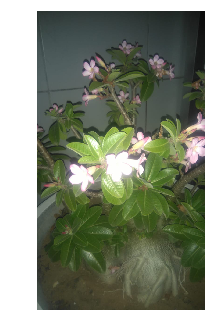

In [0]:
# Plotting the photo image
photo = Image.open('drive/My Drive/Colab/flower_photo.jpeg')
plt.imshow(photo)
plt.axis('off')

In [0]:
# Converting the jpeg image to a suitable extension (jpg)
im = Image.open('drive/My Drive/Colab/flower_photo.jpeg')
rgb_im = im.convert('RGB')
rgb_im.save('drive/My Drive/Colab/flower_photo.jpg')

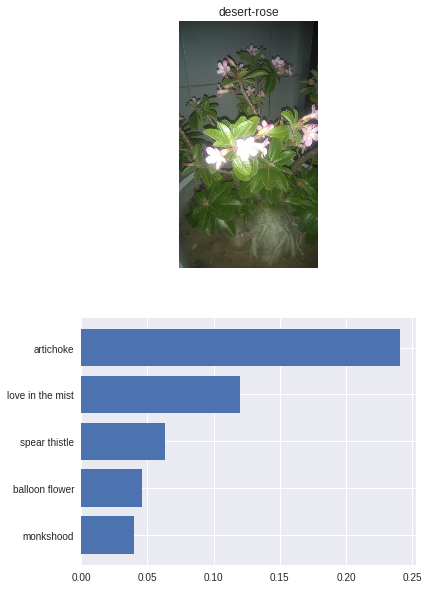

In [0]:
# The picture was moved into the desert rose test folder so it could
# be displayed its true class on top of the image bellow

# Passing the picture to the model
img_path = 'drive/My Drive/Colab/Flower_Dataset/test/85/flower_photo.jpg'
p, c = predict(img_path, model)

# Calling a random image to display its former class and top 5 predicted classes
view_classify(img_path, p, c, category_to_name)

### As we can see, the model could not correctly identify the flower type, not even on its top 5 prediction. So I checked some samples of the desert rose on the training set: 

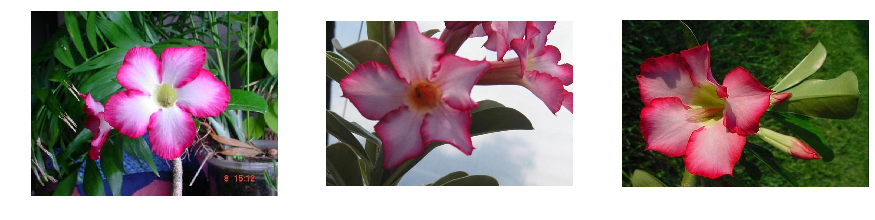

In [0]:
# Selecting a random image from the desert rose folder
img_path = 'drive/My Drive/Colab/Flower_Dataset/test/85/' + random.choice(os.listdir(test_dir + '/85/'))

# Plotting a grid of 3 images
fig=plt.figure(figsize=(15, 15))
columns = 3
rows = 1
for i in range(1, columns*rows +1):
    img = Image.open('drive/My Drive/Colab/Flower_Dataset/test/85/' + random.choice(os.listdir(test_dir + '/85/')))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')
plt.show()

### We can notice that most of the images were much closer, really focusing the rose and not the whole plant, so I cropped the same image to a picture 2 and see the model's behavior with a closer look in the rose. That's the result I got:

In [0]:
# Converting the jpeg image to a suitable extension (jpg)
im = Image.open('drive/My Drive/Colab/Flower_Dataset/test/85/flower_photo_2.jpeg')
rgb_im = im.convert('RGB')
rgb_im.save('drive/My Drive/Colab/Flower_Dataset/test/85/flower_photo_2.jpg')

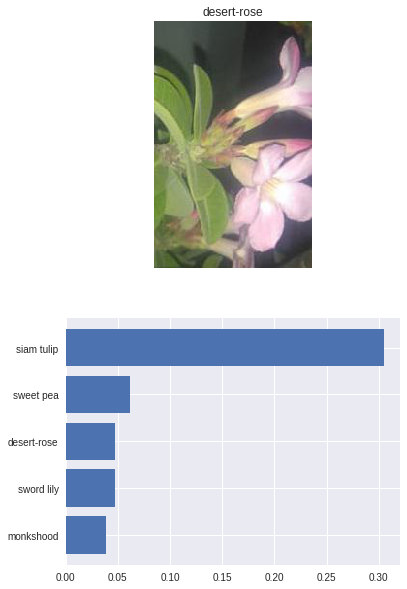

In [0]:
# Passing the picture 2 to the model
img_path = 'drive/My Drive/Colab/Flower_Dataset/test/85/flower_photo_2.jpg'
p, c = predict(img_path, model)

# Calling a random image to display its former class and top 5 predicted classes
view_classify(img_path, p, c, category_to_name)

### So for the second time, the model misclassified the species prediction; however, we can see some improvement as it classified desert rose in the third place. Hence, we can notice how the model tend to correctly classify samples.
### Going further in the visual analysis, we can also check that most of the desert rose samples in the training set have this darker pink color in comparison with the species I had thaken the photo of. Moreover, most of the desert rose pictures used for training were taken during daylight, so, I waited for the next morning, to take 2 more pictures.
### Picture 3 is a closer picture of my own light-pink desert rose on a daylight environment (so it could be more similar to the training samples), and Picture 4 is a similar photo of Picture 3, with the difference that I gladly also have a dark-pink desert flower at home, which resembles the samples' color from the training set more than the light-pink one.
### And to prove that the pictures were mine I put a note on the background with the project's name (Flower Classification) and my own (Luan Vasconcelos) written. Now we can see the model behavior on these two new pictures:

(-0.5, 773.5, 1031.5, -0.5)

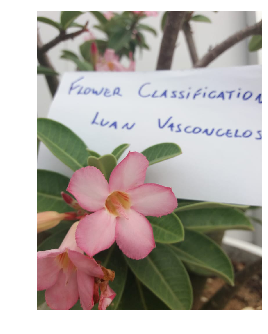

In [0]:
# Plotting picture 3
plt.imshow(Image.open('drive/My Drive/Colab/Picture_3.jpeg'))
plt.axis('off')

(-0.5, 773.5, 1031.5, -0.5)

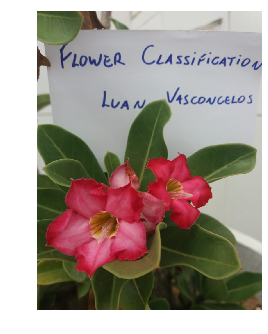

In [0]:
# Plotting picture 4
plt.imshow(Image.open('drive/My Drive/Colab/Picture_4.jpeg'))
plt.axis('off')

### Now let's crop the images to make it more similar to the trained ones and print the model's top 5 prediction for them:

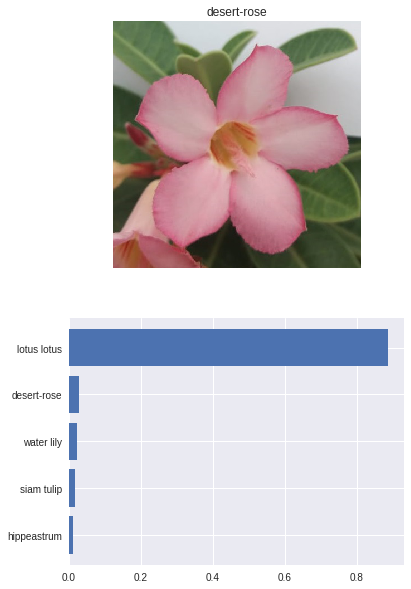

In [0]:
# Passing the Picture 3 to the model
img_path = 'drive/My Drive/Colab/Flower_Dataset/test/85/Picture_3_cropped.jpg'
p, c = predict(img_path, model)

# Calling the image to display its former class and top 5 predicted classes
view_classify(img_path, p, c, category_to_name)

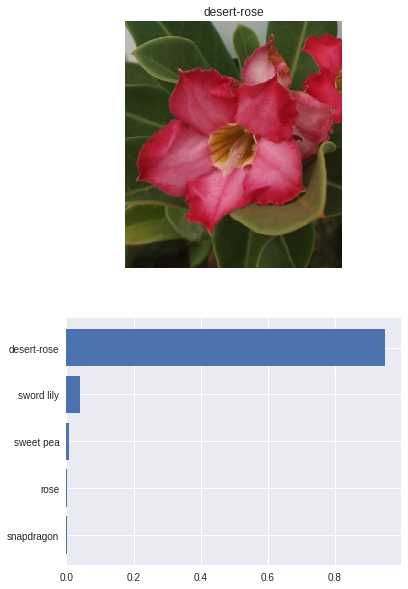

In [0]:
# Passing the Picture 4 to the model
img_path = 'drive/My Drive/Colab/Flower_Dataset/test/85/Picture_4_cropped.jpg'
p, c = predict(img_path, model)

# Calling the image to display its former class and top 5 predicted classes
view_classify(img_path, p, c, category_to_name)

### What we can see now is that the model's prediction on the light-pink desert rose yielded its correct class only on the second place, whereas for the dark-pink desert rose the model was able to correctly identify it.
### Let's see how the model behaved for the desert rose whole class on the test set:

In [0]:
# Printing the top 1 and top 5 prediction accuracy on the desert rose class
for i in range(len(results['class'])):
  if results['class'][i] == 'desert-rose':
    print(results.loc[i])
    break

class    desert-rose
top1              60
top5             100
loss        0.895103
Name: 32, dtype: object


### Interestingly the model presets only a 60% accuracy for the top 1 prediction of desert roses and 100% rate for top 5 prediction.

## 5) Conclusion

### This work covered the basics of using a pre-trained convolution neural network to be used in a project, as to build all the CNN archtecture with its weights takes a considerable time, by training a new classifier using the PyTorch framework.
### The learning rate, the dropout and the classifier structure heavily influenced on the model's generalization performance, and some different values for them were tested in order to achieve the best outcome. When the expectations were aligned with the accuracy the factor value was frozen to be used in the final result.
### With the use of real-life images of flowers the model was put to test. Its performance was visible not only by its accuracy number in each class and in the whole test set, but also by its ability to extract from 102 different species what it guesses it's the most probable ones.